## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [125]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [126]:
df= pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [127]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [128]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [129]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [130]:
g1 = df.query("group =='treatment' and landing_page != 'new_page'").count()[0]
g2 = df.query("group =='control' and landing_page != 'old_page'").count()[0]
total = g1+g2
total

3893

f. Do any of the rows have missing values?

In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [132]:
df1 = df.drop(df[(df.group == 'control') & (df.landing_page != 'old_page')].index)
df2 = df1.drop(df[(df.group == 'treatment') & (df.landing_page !='new_page')].index)

In [133]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [134]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [135]:
df2[df2.duplicated(['user_id'],keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

the information is mentioned above

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [136]:
df2.drop(labels=2893, inplace=True)

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [137]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [138]:
control = df2[df2['group'] =='control'].converted.mean()
control

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [139]:
treatment = df2[df2['group'] == 'treatment'].converted.mean()
treatment

0.11880806551510564

d. What is the probability that an individual received the new page?

In [140]:
len(df2.query("landing_page == 'new_page'"))/len(df2.landing_page)

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**Your answer goes here.**
 it seems that half of the population recived the old page and the other half received the new page
  It's clear that the treatment group did not make more conversion as the conversion through the old page is higher 

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Put your answer here.**
- Null hypothesis , the conversion rate for the old page is equal or greater than that of the new page
- alternantive hypothesis is the conversion rate for the new page is greater than that of the old page

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [141]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [142]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [143]:
n_new = len(df2.query("landing_page == 'new_page'"))
n_new

145310

d. What is $n_{old}$?

In [144]:
n_old = len(df2.query("landing_page == 'old_page'"))
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [145]:
# Simulate a Sample for the treatment Group
new_page_converted = np.random.choice([1,0], n_new, p = [p_new, 1-p_new])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [146]:
# Simulate a Sample for the control Group
old_page_converted = np.random.choice([1,0], n_old, p = [p_old, 1-p_old])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [147]:
# differences computed in from p_new and p_old
diff= new_page_converted.mean() - old_page_converted.mean()# differences computed in from p_new and p_old
diff

-0.0002567912061269967

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [148]:
# Create sampling distribution for difference in p_new-p_old simulated values
# with boostrapping
p_diffs = []
for i in range(10000):
    
    new_page_converted = np.random.choice([1, 0],n_new,replace = True,p = [p_new, 1-p_new])
    old_page_converted  = np.random.choice([1, 0],n_old,replace = True,p = [p_old, 1-p_old])
    p_diffs.append(new_page_converted.mean()-old_page_converted.mean())


i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

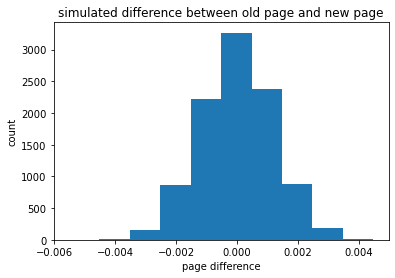

In [149]:
p_diffs=np.array(p_diffs)
#histogram of p_diff
plt.hist(p_diffs)
plt.xlabel('page difference')
plt.ylabel('count')
plt.title('simulated difference between old page and new page');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [150]:
#calculating the observed diffrence in convertion rate 
mean_control_conveted = df2[df2['group'] =='control'].converted.mean()
mean_treatment_conveted = df2[df2['group'] =='treatment'].converted.mean()
obs_diff = mean_treatment_conveted - mean_control_conveted
obs_diff

-0.0015782389853555567

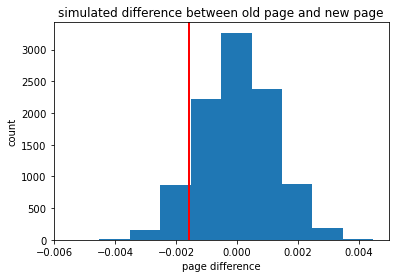

In [151]:
#histogram of p_diff
plt.hist(p_diffs)
plt.xlabel('page difference')
plt.ylabel('count')
plt.title('simulated difference between old page and new page');
plt.axvline(obs_diff,color = 'r',linewidth = 2);

In [152]:
(p_diffs > obs_diff).mean()

0.9025

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Put your answer here.**
>what we computed above is called the p_value , it tells us wether to accept the null hypothesis or
not based on the given type error rate , to accept the null hypothesis it should be greater than the suggested p-value, in our case , about 90% of our population is above the real difference which means that the new page is not doing significantly better job than the old page, so we should stick to the null hypothesis .

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [153]:
import statsmodels.api as sm

convert_old = len(df2.query('converted==1 and landing_page=="old_page"'))
convert_new = len(df2.query('converted==1 and landing_page=="new_page"')) 
n_old = len(df2.query('landing_page=="old_page"')) 
n_new = len(df2.query('landing_page=="new_page"')) 
n_new

145310

In [154]:
convert_new, convert_old

(17264, 17489)

In [155]:
n_new, n_old

(145310, 145274)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [156]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new],value=None, alternative='smaller', prop_var=False)

print(z_score,p_value)

1.3109241984234394 0.9050583127590245


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Put your answer here.**
>The z score and p-value here means that we shouldn't reject the null hypothesis , the p_value is 0.91 and is higher than the significance value of 0.05 which lead that we are not confident with 95% confidence interval that the convertion rate of the new  page is more than that of the old page

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Put your answer here.**
>**Because the dependant variable is binrary variable we will use the logistic regression** 

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [157]:
df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [158]:
import statsmodels.api as sm
lr = sm.Logit(df2['converted'],df2[['intercept','ab_page']])
results = lr.fit()


Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [159]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 21 Jun 2022   Pseudo R-squ.:               8.077e-06
Time:                        11:31:26   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**Put your answer here.**
>The p-value here is 0.190 which is larger than 0.05 which means we will stick here also with the null hypothesis
the null hypothesis here in our regression model is that the  conversion rate of the old_page and the new page
are the same , and the alternative hypothesis say that they differ and that means it's a two tailed test

>in part 2 , the null was the conversion in the old page is equal  or more than that of the new  page ,
and alternative is the conversion in the new page is higher than the old page , which lead to be a one tailed test


f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Put your answer here.**
>It's good idea to include other factors because it meay influence the conversion rate , the disadvantage is we will not be sure of the direction of that influence and our model gets more complex

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [160]:
countries_df = pd.read_csv('./countries.csv')
df3 = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df3.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [161]:
### Create the necessary dummy variables
df3[['UK','US','CA']] = pd.get_dummies(df3['country'])
df3.drop('country',axis = 1,inplace=True)
df3.head()

,timestamp,group,landing_page,converted,intercept,ab_page,UK,US,CA
user_id,,,,,,,,,
834778,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [162]:
### Fit Your Linear Model And Obtain the Results
df3['intercept'] = 1
lm1 = sm.Logit(df3['converted'],df3[['intercept','ab_page','UK','US']])
result1 = lm1.fit()
result1.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Tue, 21 Jun 2022   Pseudo R-squ.:               2.323e-05
Time:                        11:31:47   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK            -0.0408      0.027     -1.516      0.130      -0.093       0.012
US             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

countries seem to not have influence over the conversion rate as p-value of the two countries above 0.05 

In [163]:
#checking for possible interactions between country and landing page

df3['US_ab_page'] = df3['US'] * df3['ab_page']
df3['UK_ab_page'] = df3['UK'] * df3['ab_page']

df3.head()

,timestamp,group,landing_page,converted,intercept,ab_page,UK,US,CA,US_ab_page,UK_ab_page
user_id,,,,,,,,,,,
834778,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,0,0
928468,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,0,0
822059,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,1,0
711597,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0,0,0
710616,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,1,0


In [165]:
df3['intercept'] = 1

lm = sm.Logit(df3['converted'],df3[['intercept','ab_page','US','US_ab_page','UK','UK_ab_page']])
results = lm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Tue, 21 Jun 2022   Pseudo R-squ.:               3.482e-05
Time:                        11:32:32   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
US            -0.0057      0.019     -0.306      0.760      -0.043       0.031
US_ab_page     0.0314      0.027      1.181      0.238      -0.021       0.084
UK            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK_ab_page    -0.0469      0.054     -0.872      0.383      -0.152       0.059
==============================================================================
"""

### Summery on regression

**None of the interaction terms have a significant  p-value which leads that there is no evidence that countries have
influence over the landing page that will predict wether the user would convert or not**

<a id='conclusions'></a>
## Conclusions

**Based on the given information and the analysis done, there is no evidence that the new page would make more conversions than the old page , therefore it's recommended to  stick with the old page** 